# Time Series Simple Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import pandas_datareader as pdr

In [2]:
GOOG_data = pdr.DataReader('GOOG','stooq')
ABBV_data = pdr.DataReader('ABBV','stooq')

In [3]:
GOOG = GOOG_data.reset_index()
GOOG = GOOG[(GOOG['Date'] >= '2023-01-01') & (GOOG['Date'] <= '2023-12-31')]
GOOG = GOOG.reset_index().drop('index', axis=1)
GOOG.head(2)

,Date,Open,High,Low,Close,Volume
0,2023-12-29,140.68,141.435,139.9000,140.93,14880961
1,2023-12-28,141.85,142.270,140.8283,141.28,12192549


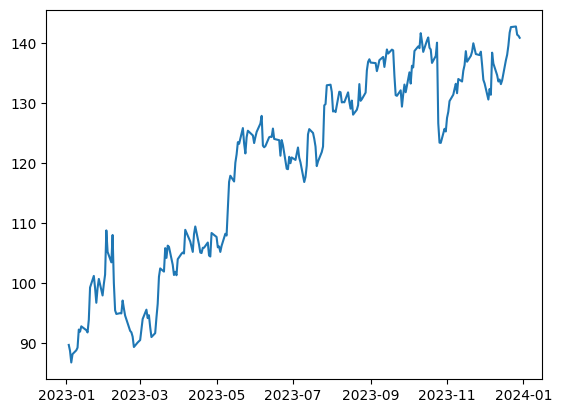

In [4]:
plt.plot(GOOG["Date"], GOOG['Close'])

## Stationary by difference

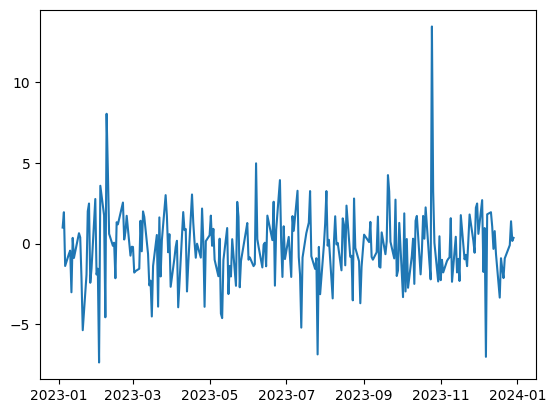

In [5]:
GOOG_st = GOOG['Close'].diff().dropna().reset_index()['Close']
plt.plot(GOOG['Date'][:-1], GOOG_st)

## Stationary by shift

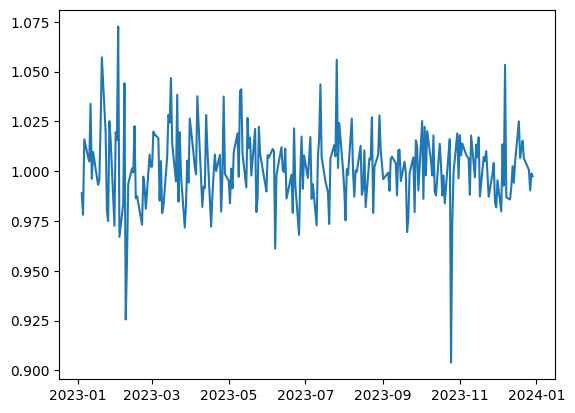

In [6]:
GOOG_st_shift = (GOOG['Close'].shift(1)/GOOG['Close']).dropna().reset_index()['Close']
plt.plot(GOOG['Date'][:-1], GOOG_st_shift)

## Fns

In [7]:
def get_errors(A, B):
  B = np.nan_to_num(np.array(B, dtype='float'))
  print('MSE', mean_squared_error(A, B))
  print('MAE', mean_absolute_error(A, B))

def plot2(x, y, pred):
  plt.plot(x, y)
  plt.plot(x, pred)

## Naive

MSE 84.53493500000002
MAE 2.2080800000000003


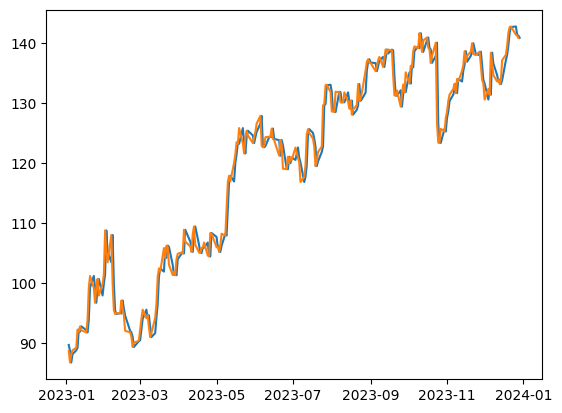

In [8]:
pred = list(GOOG['Close'])[:-1]
pred.insert(0, None)
plot2(GOOG['Date'], GOOG['Close'], pred)
get_errors(GOOG['Close'], pred)

## SMA

In [9]:
def SMA(A, weights=[], periods=3):
  pred = []
  for i in range(len(A)):
    if (i-periods)<0:
      pred.append(None)
      continue
    idx = [i - i_ for i_ in range(1, periods+1)]
    vals = A.loc[idx]
    if (weights):
      vals = vals * weights
      pred.append(vals.sum())
    else:
      pred.append(vals.mean())
  return pred

### 3MA

MSE 247.44243666666668
MAE 3.831920000000001


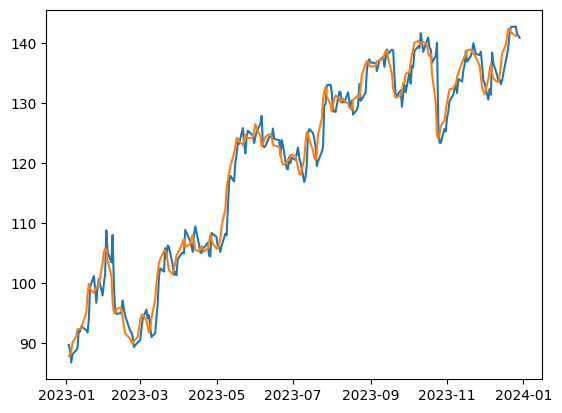

In [10]:
pred = SMA(GOOG['Close'])
plot2(GOOG['Date'], GOOG['Close'], pred)
get_errors(GOOG['Close'], pred)

### WMA

MSE 249.65035617750007
MAE 4.097334000000001


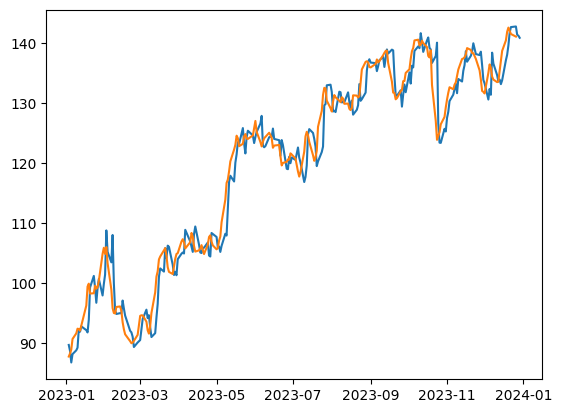

In [11]:
pred = SMA(GOOG['Close'], [0.15, 0.35, 0.5])
plot2(GOOG['Date'], GOOG['Close'], pred)
get_errors(GOOG['Close'], pred)

## Expotential MA

y_t+1 = a * Y_t + (1-a) * F_t

In [12]:
def EMA(A, a=0.8):
  pred = []
  for i in range(len(A)):
    if (i-1) < 0:
      pred.append(A.loc[i])
      continue
    p = pred[i - 1]
    c = A.loc[i - 1]
    pred.append(a*c + (1-a)*p)
  pred[0] = None
  return pred

pred = EMA(GOOG['Close'][:5])
pred

[None, 140.93, 141.21, 141.394, 142.5348]

MSE 84.80735517746739
MAE 2.2564614787010613


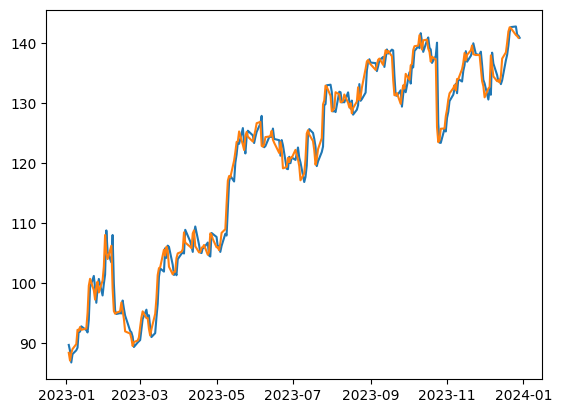

In [13]:
pred = EMA(GOOG['Close'])
plot2(GOOG['Date'], GOOG['Close'], pred)
get_errors(GOOG['Close'], pred)

In [14]:
pred = EMA(GOOG_st)
get_errors(GOOG_st, pred)

MSE 8.317750861926752
MAE 2.1667111231040828


In [15]:
pred = EMA(GOOG_st_shift)
get_errors(GOOG_st_shift, pred)

MSE 0.004595853996272914
MAE 0.02240544353868558


## Holt Double Exponential Smoothing

In [16]:
def HDES(A, a=0.8, b=0.4):
  S = []
  T = []
  pred = []
  for i in range(len(A)):
    if (i-1) < 0:
      pred.append(A.loc[i])
      S.append(A.loc[i])
      T.append(0)
      continue

    y = A.loc[i - 1]
    s_prev = S[i - 1]
    t_prev = T[i - 1]

    s = a * y + (1 - a) * (s_prev + t_prev)
    t = b * (s - s_prev) + (1 - b) * t_prev
    S.append(s)
    T.append(t)
    pred.append(s + t)

  pred[0] = None
  return pred

pred = HDES(pd.Series([1451, 1499, 1686, 1764]))
pred

[None, 1451.0, 1504.7600000000002, 1723.1088000000002]

MSE 85.75137563403806
MAE 2.3973326728541577


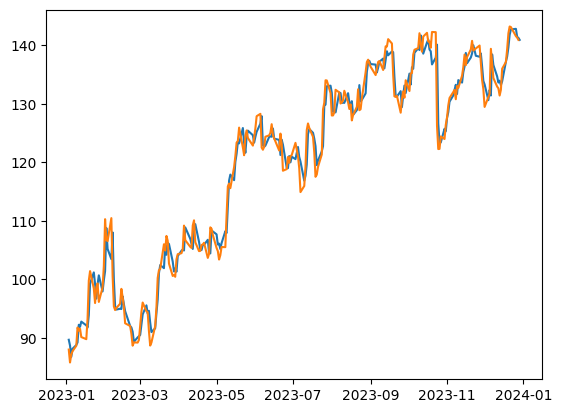

In [17]:
pred = HDES(GOOG['Close'])
get_errors(GOOG['Close'], pred)
plot2(GOOG['Date'], GOOG['Close'], pred)

In [18]:
pred = HDES(GOOG_st)
get_errors(GOOG_st, pred)

MSE 11.514324383302691
MAE 2.5537873407250946


In [19]:
pred = HDES(GOOG_st_shift)
get_errors(GOOG_st_shift, pred)

MSE 0.004826532111987674
MAE 0.02571203672918679
